In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Cargar Datos

In [3]:
carreteras_gdf = gpd.read_file("..\Datos\Carreteras\Carreteras_OSM_AMB_Disuelto.shp",encoding='utf-8')
buffers = gpd.read_file("..\Datos\Buffers\Buffers_Conjunto_25_5000.shp")
buffers.sort_values(by='layer',inplace=True)

Inspección:

In [4]:
carreteras_gdf.head(1)

osm_id  code    fclass                          name   ref oneway  \
0  5121060  5111  motorway  Autopista de la Mediterrània  AP-7      F   

   maxspeed  layer bridge tunnel  fid CODIMUNI   NOMMUNI AREAOFI  AREAPOL  \
0       120      0      F      F  1.0   080155  Badalona    None  21.0972   

  CODICOMAR CODIPROV VALIDDE      DATAALTA                layer_2  \
0        13       08    None  201907011500  Municipios_AMB copiar   

                                                path  \
0  ?layer=ogr:C%3A%2FUsers%2Fiarregui%2FGoogle%20...   

                                            geometry  
0  MULTILINESTRING ((3646161.610 2054516.010, 364...

In [5]:
buffers.head(1)

field_1  CODI EOI NOM ESTACI  TIPUS ESTA AREA URBAN  ALTITUD    LATITUD  \
0        0   8015021   Badalona  background      urban        7  41.443985   

   LONGITUD             Contaminan Ozono layer  \
0  2.237899  NO, NO2, NOX, O3, SO2    Si  b100   

                                                path  \
0  C:/Users/iarregui/Google Drive/3 - UOC/Q6/TFM/...   

                                            geometry  
0  POLYGON ((3671099.682 2071480.873, 3671099.632...

Visualización Carreteras y Buffers:

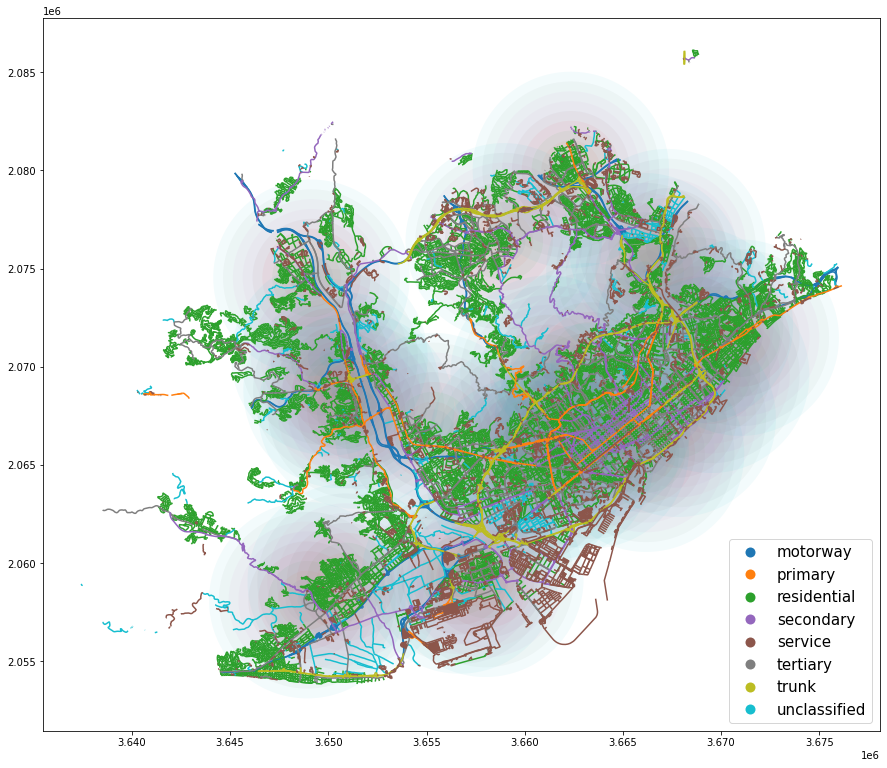

In [6]:
f, ax = plt.subplots(1,1,figsize=(15,15))
carreteras_gdf.plot(column='fclass',ax=ax,
                    legend=True,legend_kwds={'loc': 'lower right','fontsize':15})
buffers.plot(column='layer',ax=ax, alpha=0.05)
plt.show()

## Comprobar CRS de cada gdf

In [7]:
buffers.crs

<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Turkey; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.579299533, 24.603629139001, 44.820545196533, 84.722623821813)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azi

In [8]:
carreteras_gdf.crs

<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Turkey; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.579299533, 24.603629139001, 44.820545196533, 84.722623821813)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azi

# Calculo longitud carreteras por buffer

Definir lista de buffers, estaciones y codigos de estaciones:

In [9]:
buf = ['b25','b50','b100','b300','b500','b1000', 'b1500', 'b2000','b2500', 'b3000','b3500', 'b4000','b4500','b5000']
est = list(buffers['NOM ESTACI'].unique())
est_cod = list(buffers['CODI EOI'].unique())

Calculo Distancias Carreteras por Buffer:

In [10]:
# Definición DF donde se pegarán los datos de longitud:
dfBufCar=pd.DataFrame(est_cod,columns=['CODI EOI'])
dfBufCar['ESTACION'] = est
# Calculo
for i,v in enumerate(buf):
    print(f'{i+1} - Procesando {v}...')
    # Filtrar buffers
    df_buffer = buffers[buffers['layer']== v ]
    # Intersección carreteras y buffer
    df_aux = gpd.overlay(carreteras_gdf, df_buffer, how='intersection')
    # Calculo longitud carreteras
    df_aux['LongitudCarretera']=0
    for i in range(df_aux.shape[0]):
        df_aux.iloc[i,36]=df_aux.iloc[i,35].length
    # Agrupación por Codigo Estación y Clase de Carretera - Suma longitud Carretera
    df_aux1 = df_aux.groupby(by=['CODI EOI','fclass']).sum('LongitudCarretera').reset_index(drop=False)
    df_aux1['buffer'] = v
    df_aux1['buffer_road'] = df_aux1['fclass'] + '_' + df_aux1['buffer']
    df_aux1 = df_aux1[['CODI EOI','buffer_road','LongitudCarretera']]
    # Spread de columnas
    df_aux1 = pd.crosstab(index=df_aux1['CODI EOI'],
                          columns=df_aux1['buffer_road'],
                          values=df_aux1['LongitudCarretera'],
                          aggfunc='mean').reset_index(drop=False)
    # Join con dfBufCar
    dfBufCar = dfBufCar.merge(df_aux1, how='left',on='CODI EOI')
# Substituir NaN por 0
dfBufCar = dfBufCar.replace(np.nan, 0)
# Ordenar DF por Codigo EOI
dfBufCar.sort_values(by='CODI EOI',inplace=True)

1 - Procesando b25...
2 - Procesando b50...
3 - Procesando b100...
4 - Procesando b300...
5 - Procesando b500...
6 - Procesando b1000...
7 - Procesando b1500...
8 - Procesando b2000...
9 - Procesando b2500...
10 - Procesando b3000...
11 - Procesando b3500...
12 - Procesando b4000...
13 - Procesando b4500...
14 - Procesando b5000...


In [11]:
dfBufCar.to_csv('..\Datos\Datos_Procesados\Estacion_Buffes_LongitudCarretera.csv')